# MNIST CNN Project - Saving Model

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### 데이터 로딩(Load Data)

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


#### 하이퍼 파라미터 설정

In [3]:
# Hyper Prarameters
training_epochs = 15
batch_size = 100
learning_rate = 0.001

In [4]:
class Model:
    
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._build_net()
        
    def _build_net(self):
        
        # 입력 받은 이름으로 변수 명을 설정한다.
        with tf.variable_scope(self.name):
            
            # Boolean Tensor 생성 for dropout
            # tf.layers.dropout( training= True/Fals) True/False에 따라서 학습인지 / 예측인지 선택하게 됨
            # default = False
            self.training = tf.placeholder(tf.bool)
            
            # 입력 그래프 생성
            self.X = tf.placeholder(tf.float32, [None, 784])
            # 28x28x1로 사이즈 변환
            X_img = tf.reshape(self.X, [-1, 28, 28, 1])
            self.Y = tf.placeholder(tf.float32, [None, 10])
            
            # Convolutional Layer1 
            conv1 = tf.layers.conv2d(inputs=X_img, filters=32, kernel_size=[3,3], padding='SAME', activation=tf.nn.relu)
            # Pooling Layer1
            pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=2, padding="SAME" )
            # Dropout Layer1
            dropout1 = tf.layers.dropout(inputs=pool1, rate=0.7, training=self.training)
            

            # Convolutional Layer2
            conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3,3], padding='SAME', activation=tf.nn.relu)
            # Pooling Layer2
            pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],strides=2, padding='SAME' )
            # Dropout Layer2
            dropout2 = tf.layers.dropout(inputs=pool2, rate=0.7, training=self.training)
            
            
            # Convolutional Layer3
            conv3 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
            # Pooling Layer3
            pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2,2], strides=2, padding='SAME')
            # Dropout Layer3
            dropout3 = tf.layers.dropout(inputs=pool3, rate=0.7, training=self.training)
            
            # Dense Layer4 with Relu
            flat = tf.reshape(dropout3, [-1, 128*4*4])
            dense4 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
            # Dropout layer4
            dropout4 = tf.layers.dropout(inputs=dense4, rate=0.5, training=self.training)
            
            # Dense Layer5 with Relu
            dense5 = tf.layers.dense(inputs=dropout4, units=1050, activation=tf.nn.relu)
            # Dropout Layer5
            dropout5 = tf.layers.dropout(inputs=dense5, rate=0.5, training=self.training)
            
            
            # Logits layer : Final FC Layer5 Shape = (?, 625) -> 10
            self.logits = tf.layers.dense(inputs=dropout5, units=10)

        # Cost Function
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)
        
        # Test Model
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            
    def train(self, x_data, y_data, training = False):
        return self.sess.run([self.cost, self.optimizer], feed_dict={self.X: x_data, self.Y:y_data, self.training:training})
    
    def predict(self, x_test, training = False):
        return self.sess.run(self.logits, feed_dict={self.X : x_test, self.training:training})
    
    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy, feed_dict={self.X: x_test, self.Y : y_test, self.training: training})

#### 세션 생성

In [5]:
# Initialize
sess = tf.Session()

#### Ensemble

In [6]:
models = []
num_models = 5
for m in range(num_models):
    models.append(Model(sess, "model"+str(m)))

#### 학습

In [7]:
sess.run(tf.global_variables_initializer())

In [8]:
for epoch in range(training_epochs):
    avg_cost_list = np.zeros(len(models))
    total_batch = int(mnist.train.num_examples / batch_size)
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        
        # Train each model
        for m_idx, m in enumerate(models):
            c, _ = m.train(batch_xs, batch_ys)
            avg_cost_list[m_idx] += c / total_batch
        
    print('Epoch: ', '%04d' %(epoch + 1), 'Cost = ', avg_cost_list)
print('Training Finished')

Epoch:  0001 Cost =  [ 0.16365541  0.15805094  0.15816862  0.16383813  0.16415393]
Epoch:  0002 Cost =  [ 0.04496201  0.0429047   0.04390503  0.04575218  0.04640629]
Epoch:  0003 Cost =  [ 0.03376844  0.03230815  0.03093393  0.0311225   0.03254555]
Epoch:  0004 Cost =  [ 0.02652556  0.02339662  0.02443642  0.02445769  0.02463311]
Epoch:  0005 Cost =  [ 0.0198066   0.01852332  0.01969138  0.01961155  0.0213654 ]
Epoch:  0006 Cost =  [ 0.0176054   0.01526843  0.01563099  0.01782834  0.01737436]
Epoch:  0007 Cost =  [ 0.01473158  0.01403986  0.01337373  0.01477611  0.01201437]
Epoch:  0008 Cost =  [ 0.01506129  0.01503563  0.0140624   0.01302052  0.01405509]
Epoch:  0009 Cost =  [ 0.01078236  0.01027405  0.01193813  0.01211779  0.0119099 ]
Epoch:  0010 Cost =  [ 0.01193268  0.0116962   0.01067205  0.01128916  0.0125835 ]
Epoch:  0011 Cost =  [ 0.00784031  0.0101482   0.00891004  0.01000892  0.01003456]
Epoch:  0012 Cost =  [ 0.00956921  0.00852514  0.01168503  0.00831856  0.00963581]
Epoc

#### 테스트 모델

In [30]:
test_size = len(mnist.test.labels)
predictions = np.zeros([test_size, 10])
best_models = []

In [31]:
for m_idx, m in enumerate(models):
    best_models.append(m.get_accuracy(mnist.test.images, mnist.test.labels))
    print(m_idx, 'Accuracy: ', best_models[m_idx] )
    p = m.predict(mnist.test.images)
    predictions += p 

0 Accuracy:  0.9925
1 Accuracy:  0.9918
2 Accuracy:  0.9923
3 Accuracy:  0.9928
4 Accuracy:  0.9901


In [32]:
ensemble_correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(mnist.test.labels, 1))
ensemble_accuracy = tf.reduce_mean(tf.cast(ensemble_correct_prediction, tf.float32))
print('Ensemble accuracy:', sess.run(ensemble_accuracy))

Ensemble accuracy: 0.9954


#### 모델 저장

- 5개의 모델 중 가장 뛰어난 모델 선택 후 저장

In [39]:
best_model = models[np.argmax(best_models)]

In [51]:
saver = tf.train.Saver()
save_path = saver.save(best_model.sess, './mnist_cnn.ckpt')
print("Model saved to %s" % save_path)

Model saved to ./mnist_cnn.ckpt


#### 모델 직접 테스트

- Validation Data에서 임의의 mnist 데이터 불러오기

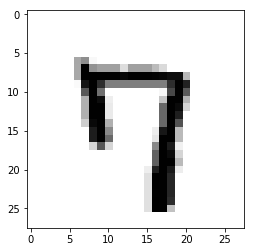

In [45]:
image_a = mnist.validation.images[np.random.randint(0, len(mnist.validation.images))]
plt.imshow(image_a.reshape([28, 28]), cmap='Greys')

In [49]:
image_a = image_a.reshape([1, 784])
print("MNIST predicted Number : ", np.argmax(best_model.predict(image_a)))

MNIST predicted Number :  7


#### 참고 사항
- Tensor 이름 확인(Tensor 이름을 정의하지 않았을 때)

In [58]:
best_model.logits

<tf.Tensor 'model3/dense_3/BiasAdd:0' shape=(?, 10) dtype=float32>

In [59]:
best_model.X

<tf.Tensor 'model3/Placeholder_1:0' shape=(?, 784) dtype=float32>

In [60]:
best_model.training

<tf.Tensor 'model3/Placeholder:0' shape=<unknown> dtype=bool>